In [1]:
# Import library yang dibutuhkan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from implicit import als
from scipy.sparse import coo_matrix
from sklearn.metrics import average_precision_score


In [3]:
# Memuat data
data_path = 'data-books/train.csv'  # Gantilah path ini sesuai lokasi file Anda
data = pd.read_csv(data_path)

# Memuat data test
test_data_path = 'data-books/data_target_users_test.csv'  # Gantilah path ini sesuai lokasi file Anda
test_data = pd.read_csv(test_data_path)

# Menampilkan 5 baris pertama untuk memverifikasi data yang dimuat
print(data.head())
print(test_data.head())

# Menggunakan factorize untuk membuat indeks numerik pada test_data
test_data['user_id_index'] = pd.factorize(test_data['user_id'])[0]


   user_id     item_id
0        8  0002005018
1        8  074322678X
2        8  0887841740
3        8  1552041778
4        8  1567407781
   user_id
0        8
1       99
2      114
3      160
4      183


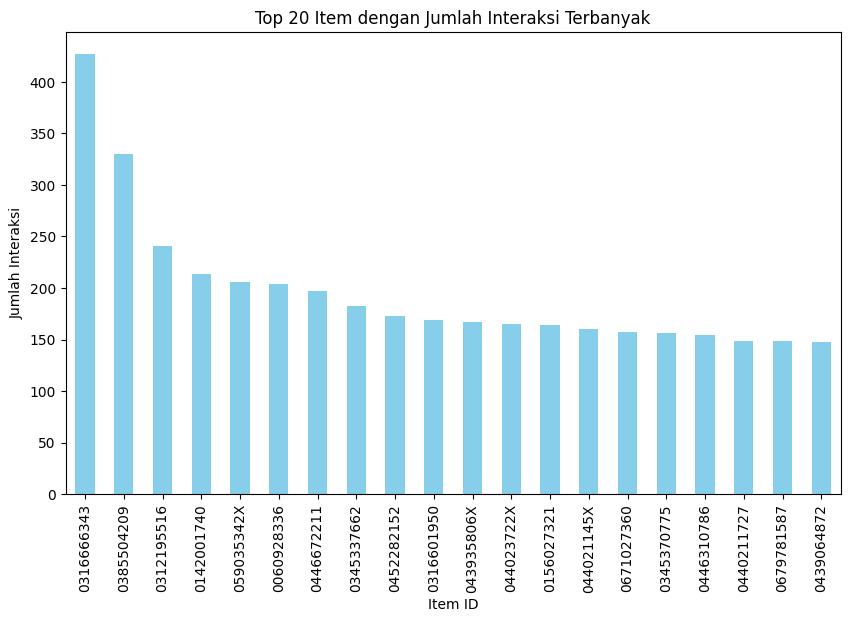

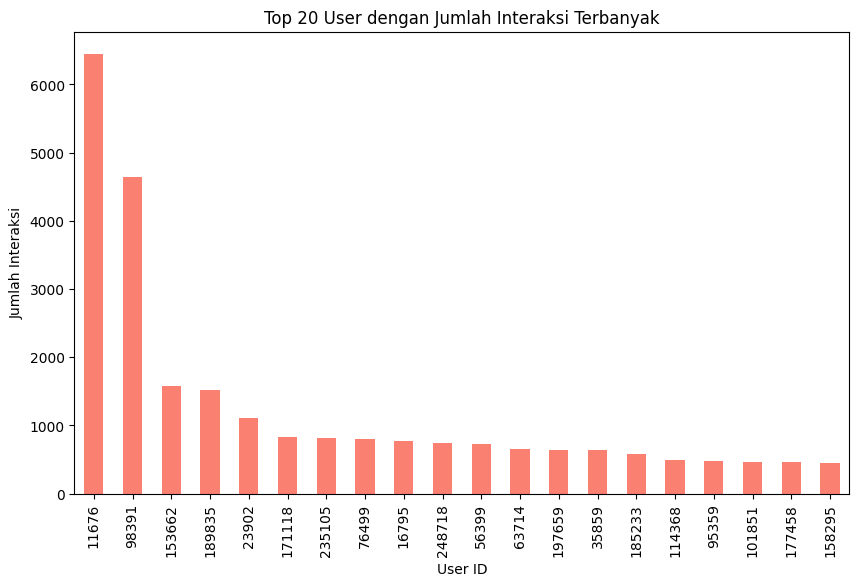

In [5]:
# 1. Data Understanding: Visualisasi interaksi item terbanyak dan interaksi user terbanyak
# Menghitung jumlah interaksi per item
item_popularity = data['item_id'].value_counts()

# Menghitung jumlah interaksi per user
user_activity = data['user_id'].value_counts()

# Visualisasi jumlah interaksi per item (Top 20)
plt.figure(figsize=(10,6))
item_popularity.head(20).plot(kind='bar', color='skyblue')
plt.title('Top 20 Item dengan Jumlah Interaksi Terbanyak')
plt.xlabel('Item ID')
plt.ylabel('Jumlah Interaksi')
plt.show()

# Visualisasi jumlah interaksi per user (Top 20)
plt.figure(figsize=(10,6))
user_activity.head(20).plot(kind='bar', color='salmon')
plt.title('Top 20 User dengan Jumlah Interaksi Terbanyak')
plt.xlabel('User ID')
plt.ylabel('Jumlah Interaksi')
plt.show()


In [7]:
# 2. Model Baseline: Item Popularity (Rekomendasi untuk User yang Diuji)
# Mengambil 10 item terpopuler sebagai rekomendasi untuk setiap pengguna
top_10_popular_items = item_popularity.head(10).index.tolist()

# Membuat rekomendasi untuk setiap user dalam test data (hanya user_id)
user_recommendations_baseline = pd.DataFrame({
    'user_id': test_data['user_id'],
    'recommended_items': [top_10_popular_items] * len(test_data)
})

# Menampilkan beberapa rekomendasi untuk user
print("Rekomendasi Model Baseline:")
print(user_recommendations_baseline.head())

# Evaluasi MAP@10 untuk model Baseline
def calculate_map_at_k(recommended_items, actual_items, k=10):
    ap_scores = []
    
    for user_recommendations, user_actual in zip(recommended_items, actual_items):
        # Membatasi rekomendasi hingga top-k
        user_recommendations = user_recommendations[:k]
        relevant_items = set(user_recommendations) & set(user_actual)
        precision_at_k = len(relevant_items) / k
        ap_scores.append(precision_at_k)
    
    return np.mean(ap_scores)

# Karena test_data hanya berisi user_id, kita mengambil interaksi aktual dari train_data
baseline_recommendations = [top_10_popular_items] * len(test_data)  # Rekomendasi model baseline
baseline_actual_items = []

# Mengambil interaksi aktual untuk perhitungan MAP@10 berdasarkan data latih
for user_id in test_data['user_id']:
    actual_items = data[data['user_id'] == user_id]['item_id'].tolist()  # Menggunakan data asli untuk mendapatkan item_id
    baseline_actual_items.append(actual_items)

# Menghitung MAP@10 untuk model Baseline
map_baseline = calculate_map_at_k(baseline_recommendations, baseline_actual_items, k=10)
print(f'MAP@10 Model Baseline: {map_baseline}')


Rekomendasi Model Baseline:
   user_id                                  recommended_items
0        8  [0316666343, 0385504209, 0312195516, 014200174...
1       99  [0316666343, 0385504209, 0312195516, 014200174...
2      114  [0316666343, 0385504209, 0312195516, 014200174...
3      160  [0316666343, 0385504209, 0312195516, 014200174...
4      183  [0316666343, 0385504209, 0312195516, 014200174...
MAP@10 Model Baseline: 0.016892476217930243


In [9]:
# 3. Model Advanced: Alternating Least Squares (ALS)
# Membuat matriks interaksi user-item untuk digunakan pada model ALS

# Membuat matriks interaksi user-item dari data
user_item_matrix = data.groupby(['user_id', 'item_id']).size().reset_index(name='interactions')

# Pastikan 'user_id' dan 'item_id' bertipe string
user_item_matrix['user_id'] = user_item_matrix['user_id'].astype(str)
user_item_matrix['item_id'] = user_item_matrix['item_id'].astype(str)

# Menghapus baris dengan nilai NaN pada 'user_id' atau 'item_id'
user_item_matrix = user_item_matrix.dropna(subset=['user_id', 'item_id'])

# Pastikan 'user_id' dan 'item_id' memiliki nilai yang valid dan tidak kosong
user_item_matrix = user_item_matrix[user_item_matrix['user_id'].str.strip() != '']
user_item_matrix = user_item_matrix[user_item_matrix['item_id'].str.strip() != '']

# Menggunakan factorize untuk membuat indeks numerik
user_item_matrix['user_id_index'] = pd.factorize(user_item_matrix['user_id'])[0]
user_item_matrix['item_id_index'] = pd.factorize(user_item_matrix['item_id'])[0]

# Subsampling: ambil 5% dari data untuk pelatihan
subsampled_data = user_item_matrix.sample(frac=0.05, random_state=42)

# Membagi data subsampled menjadi train dan test untuk model ALS
train_data, test_data_split = train_test_split(subsampled_data, test_size=0.2, random_state=42)

# Membuat matriks interaksi sparse untuk data train dan test
train_interactions = coo_matrix((train_data['interactions'], 
                                 (train_data['user_id_index'], train_data['item_id_index'])))
test_interactions = coo_matrix((test_data_split['interactions'], 
                                (test_data_split['user_id_index'], test_data_split['item_id_index'])))

# Menginisialisasi dan melatih model ALS dengan parameter yang lebih tinggi
model_als = als.AlternatingLeastSquares(factors=50, regularization=0.1, iterations=20, random_state=42)

# Menambahkan log untuk melacak proses
print("Melatih model ALS...")

# Melatih model
model_als.fit(train_interactions)


Melatih model ALS...


D:\Anaconda\Lib\site-packages\implicit\cpu\als.py:95: RuntimeWarning: Intel MKL BLAS is configured to use 6 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'MKL_NUM_THREADS=1' or by callng 'threadpoolctl.threadpool_limits(1, "blas")'. Having MKL use a threadpool can lead to severe performance issues
  check_blas_config()
D:\Anaconda\Lib\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

In [11]:
# 4. Evaluasi: Menghitung MAP@10 untuk model ALS

# Membuat rekomendasi untuk setiap user di test data
user_recommendations_als = []
user_actual_items = []

# Memastikan kita menggunakan user_id_index yang valid
for user_id in test_data['user_id']:
    # Mendapatkan index numerik untuk user_id dari test_data
    user_index = test_data[test_data['user_id'] == user_id].index[0]
    user_id_index = test_data.iloc[user_index]['user_id_index']
    
    # Pastikan user_id_index valid dan ada di train_interactions
    if user_id_index < train_interactions.shape[0]:
        # Mengakses baris tertentu dalam matriks sparse menggunakan getrow() dengan user_id_index
        user_row = train_interactions.getrow(user_id_index)  # Dapatkan interaksi untuk user_id_index
        
        # Menghasilkan 10 rekomendasi untuk user_id tertentu
        recommended = model_als.recommend(user_id_index, user_row, N=10)
        user_recommendations_als.append([item[0] for item in recommended])  # Menyimpan 10 rekomendasi
        
        # Menyimpan interaksi aktual untuk perhitungan MAP@10
        actual_items = train_data[train_data['user_id_index'] == user_id_index]['item_id_index'].tolist()
        user_actual_items.append(actual_items)
    else:
        print(f"Warning: user_id_index {user_id_index} tidak ada dalam train_interactions")

# Menghitung MAP@10 untuk model ALS
map_at_10 = calculate_map_at_k(user_recommendations_als, user_actual_items, k=10)
print(f'MAP@10 Model ALS: {map_at_10}')


MAP@10 Model ALS: 0.0
